## ¿Por que estan dificil saber quien va a ir a Votar?
##Hay dos motivos muy humanos para explicarlo: que las personas somos optimistas en exceso y que nos gusta quedar bien

## https://elpais.com/politica/2019/04/07/actualidad/1554639446_309283.html

## Importamos las librerias necesarias 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
%matplotlib inline

In [185]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor as knnr
import seaborn as sns
sns.set_style("whitegrid")
import os
import pickle

In [2]:
df_2009 = pd.read_csv('../TFM/1_Data/GDataframe_2009.csv')
df_2009.head()

Unnamed: 0  Código municipio                          Municipio  2009_1  \
0           0             48001                            Abadiño   43.75   
1           1             20001                       Abaltzisketa   25.00   
2           2             48002  Abanto y Ciérvana-Abanto Zierbena   30.77   
3           3             20002                              Aduna   80.00   
4           4             20016                                Aia   33.33   

   2009_2  2009_3  2009_4  2010_5  2009_6  2009_7     ...      2009_57  \
0    8.65     0.0  185.36    33.4    0.00    4.55     ...        10.40   
1    0.00     0.0  269.94    37.6    0.00    0.00     ...        92.02   
2    9.60     0.0  250.51    37.0    0.00    2.63     ...        14.60   
3   36.14     0.0  326.34    23.4   46.62   17.99     ...        37.30   
4   15.63     0.0  114.60    28.5    0.00    5.03     ...         9.97   

   2009_58  2006_59   2007  2009_61  2001_62   2010  2009_64  2011_elecc  \
0    12.90     0.88  12.94     5.86    11.24   7.60     8.50       71.16   
1    18.69     6.53  10.73    20.61    31.40  22.98    14.93       66.13   
2     9.29     0.82   8.60     8.15    10.63  21.09    18.13       65.24   
3    12.05     1.59   8.34    29.35    14.69   8.29    24.10       86.46   
4    15.63     3.98  20.39    17.74    17.67  11.07    14.97       69.73   

  2011_partic  
0           2  
1           2  
2           2  
3           1  
4           2  

[5 rows x 69 columns]

## Para hacer una prediccion mas realista sobre el porcentaje de participacion electoral en las elecciones municipales en los 245 municipios vascos, vamos a utilizar un numero de participacion entero (tanto como etiqueta para el aprendizaje automatico del modelo de regresion como para el resultado), por ello creamos una funcion.

In [187]:
def part_integ(num):
    try:
        return int(num)
    except:
        return 0

part_integ(67.90)
        

67

In [188]:
df_2009['2011_elecc'] = df_2009['2011_elecc'].apply(part_integ)

In [189]:
pd.options.display.max_columns=None
df_2009.head()

Unnamed: 0  Código municipio                          Municipio  2009_1  \
0           0             48001                            Abadiño   43.75   
1           1             20001                       Abaltzisketa   25.00   
2           2             48002  Abanto y Ciérvana-Abanto Zierbena   30.77   
3           3             20002                              Aduna   80.00   
4           4             20016                                Aia   33.33   

   2009_2  2009_3  2009_4  2010_5  2009_6  2009_7  2009_8  2009_9  2009_10  \
0    8.65     0.0  185.36    33.4    0.00    4.55    0.00     2.0    96.44   
1    0.00     0.0  269.94    37.6    0.00    0.00    0.00     3.0    96.71   
2    9.60     0.0  250.51    37.0    0.00    2.63    9.77     3.0    98.08   
3   36.14     0.0  326.34    23.4   46.62   17.99    0.00     1.0    96.71   
4   15.63     0.0  114.60    28.5    0.00    5.03    4.98     3.0    98.90   

   2009_11  2009_12  2011_13  2009_14  2009_15  2009_16  2001_17  2009_18  \
0     0.00     6.04   145.52    11.71     7.30   201.11    88.98    23.68   
1     0.00     3.12   154.65     0.00     0.00    28.21   100.00    32.14   
2     0.00     0.41   184.19     9.12     4.56   595.49    94.70    23.48   
3     0.00    -2.41   294.39     2.49     4.99    57.29   100.00    32.30   
4    27.75     4.03   156.28     3.06     3.06    34.96    98.11    38.45   

   2009_19  2009_20  2005_21  2005_22  2009_23  2009_24  2005_25  2011_26  \
0     2.74     2.75   212.71    44.28   100.00     3.41    43.85     73.8   
1     0.00     0.00   261.93    49.18     0.00     7.69    52.75     71.6   
2     3.09     3.11   480.39    92.71    88.17     3.40    42.44     67.2   
3     0.00     0.00   301.70    39.12     0.00     5.00    52.75     66.1   
4     4.98     5.11   331.52    64.61    83.33     4.82    28.60     73.4   

   2009_27  2009_28  2009_29  2009_30  2009_31   2012  2009_33  2009_34  \
0    49.69    46.73    13.71    16.76    19.97   4.83    63.27     6.06   
1    43.61    69.89    18.35    16.67     4.17  35.00    79.17    15.82   
2    47.90    51.52    15.68    21.74    13.04   2.39    65.22     6.22   
3    91.57    55.43    14.46    16.53    26.45   6.56    57.02    17.46   
4    43.87    59.58    15.63    21.78    26.22  32.07    52.00    16.85   

   2009_35  2009_36  2009_37  2009_38  2009_39  2009_40  2009_41  2009_42  \
0    13.95   289.99    10.94     1.38     0.73    20.38     9.44     0.00   
1    18.67   585.88     0.00     0.00     0.90    12.27     0.00     0.00   
2    13.99   240.10     7.20     1.04     0.76     4.52     0.00    61.39   
3    19.20  -900.80     0.00     0.00     1.79     9.32     0.00     0.00   
4    17.06   219.79     4.98     0.00     0.72   365.22     0.00    59.41   

   2010_43  2010_44  2010_45  2011_46  2009_47  2009_48  2011_49  2009_50  \
0    19.51    56.11    16.89    94.05     4.16   7260.0    66.02     0.55   
1    14.75    43.53    11.51   100.00     1.90    316.0    74.44     0.00   
2    20.98    55.96    16.29    84.89     1.63   9647.0    80.36     1.34   
3    16.31    53.21    17.38   100.00     2.99    401.0    81.70     2.33   
4    13.06    51.44    16.77   100.00     4.90   1958.0    75.42     0.50   

   2009_51  2009_52  2005_53   2005  2006_55  2009_56  2009_57  2009_58  \
0     4.55     2.41     1.16  55.01    90.64     8.75    10.40    12.90   
1     9.49     0.26     0.18  50.36   110.75   103.45    92.02    18.69   
2     0.00    10.19     2.16  38.46    76.86     8.60    14.60     9.29   
3    17.46     4.54     3.71  66.71   108.36     5.03    37.30    12.05   
4    10.73     0.79     0.73  51.96   109.75     4.49     9.97    15.63   

   2006_59   2007  2009_61  2001_62   2010  2009_64  2011_elecc  2011_partic  
0     0.88  12.94     5.86    11.24   7.60     8.50          71            2  
1     6.53  10.73    20.61    31.40  22.98    14.93          66            2  
2     0.82   8.60     8.15    10.63  21.09    18.13          65           

## Por un lado los 64 predictores

In [190]:
X_pred09 = df_2009.drop(['Unnamed: 0','Código municipio', 'Municipio', '2011_elecc','2011_partic'], axis=1).values

## Por otro la etiqueta a utilizar en el modelo

In [191]:
y = df_2009[['2011_elecc']].values

## En el caso de regresiones debemos utilizar arrays por lo que habra que transformar el dataframe de los predictores antes

In [197]:
X = np.array(X_pred09)


 
regressors_names = [
    "Linear Regression", 'K nearest neighbors',
    'Decision Tree Regressor','Random Forest Regressor'
]
 
regressors = [
    LinearRegression(),
    knnr(),
    dtr(),
    RandomForestRegressor()
]

## Vamos a utilizar cuatro modelos de regresion; lineal, K vecinos, Decision Tree y Random Forest. 
## Vamos a entrenar los cuatro modelos con los datos de 2011 (en este caso como tenemos los datos del 2015 para hacer de test nos lo podemos permitir)

In [198]:
lmodel = LinearRegression(n_jobs=1)
lmodel.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [199]:
mean_squared_error(df_2009['2011_elecc'],lmodel.predict(X))

27.54713314858559

In [200]:
rmodel=RandomForestRegressor(max_depth=11)
rmodel.fit(X,y)

/home/vant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [201]:
mean_squared_error(df_2009['2011_elecc'],rmodel.predict(X))

8.269734222744502

In [202]:
k_model = knnr(n_neighbors=1)
k_model.fit(X,y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform')

In [203]:
mean_squared_error(df_2009['2011_elecc'],k_model.predict(X))

0.0

In [204]:
d_model = dtr(max_depth=11)
d_model.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [205]:
mean_squared_error(df_2009['2011_elecc'],d_model.predict(X))

1.987424684159378

In [206]:
d_model.predict(X)[0:5]

array([71., 66., 65., 86., 69.])

In [207]:
df_2009['2011_elecc'][0:5]

0    71
1    66
2    65
3    86
4    69
Name: 2011_elecc, dtype: int64

## Una vez entrenado los modelos, testeamos los cuatro modelos con los datos del 2015

## Para comprobar que modelo es el mejor en este caso de regresion una buena metrica a utilizar es la media de error cuadrado, cogiendo el modelo que menor valor que tenga.

In [3]:
df_2013 = pd.read_csv('../TFM/1_Data/GDataframe_2013.csv')

In [4]:
df_2013['2015_elecc'] = df_2013['2015_elecc'].fillna(70.13)

In [210]:
df_2013['2015_elecc'].describe()

count    245.000000
mean      71.025224
std        8.428447
min       31.370000
25%       64.370000
50%       70.130000
75%       77.930000
max       91.530000
Name: 2015_elecc, dtype: float64

In [211]:
df_2013.head()

Unnamed: 0  Código municipio                          Municipio  2009_1  \
0           0             48001                            Abadiño   43.75   
1           1             20001                       Abaltzisketa   25.00   
2           2             48002  Abanto y Ciérvana-Abanto Zierbena   30.77   
3           3             20002                              Aduna   80.00   
4           4             20016                                Aia   33.33   

   2013_2  2009_3  2009_4  2013_5  2009_6  2013_7  2009_8  2013_9  2013_10  \
0    7.49     0.0  185.36    32.3    0.00    5.83    0.00     3.0    98.90   
1    3.03     0.0  269.94    39.6    0.00   22.29    0.00     3.0    99.18   
2   12.65     0.0  250.51    39.7    0.00    2.89    9.77     3.0    99.45   
3   56.03     0.0  326.34    25.8   46.62   17.81    0.00     1.0    99.18   
4   10.30     0.0  114.60    31.5    0.00    4.88    4.98     2.0   100.00   

   2013_11  2013_12  2014_13  2013_14  2013_15  2013_16    2001  2013_18  \
0     0.00     4.14   176.79     8.96     5.48   207.05   88.98    22.93   
1     0.00    -9.09   152.31     0.00     0.00    28.80  100.00    55.94   
2     0.00    -0.62   178.40     7.71     3.81   603.09   94.70    26.77   
3     0.00    30.17   282.51     2.16     2.16    65.01  100.00    32.95   
4    27.52     3.92   154.29     3.43     2.94    37.02   98.11    50.95   

   2014_19  2013_20  2005_21  2005_22  2011_23  2013_24  2005_25  2011_26  \
0     2.66     2.68   212.71    44.28    98.55     3.58    43.85     73.8   
1     0.00     0.00   261.93    49.18     0.00     0.00    52.75     71.6   
2     3.11     3.07   480.39    92.71    84.95     3.53    42.44     67.2   
3     0.00     0.00   301.70    39.12     0.00     3.85    52.75     66.1   
4     4.88     4.91   331.52    64.61    63.16     2.06    28.60     73.4   

   2013_27  2013_28  2013_29  2013_30  2013_31  2013_32  2013_33  2013_34  \
0    44.78    54.63    15.93    12.24    19.00     6.75    62.01     5.88   
1    48.48    73.68    16.67     5.13     2.56    41.03    51.28    18.18   
2    51.22    52.23    15.87    20.29    13.43     2.19    64.09     4.94   
3    64.66    59.23    12.91    14.41    30.51     7.63    47.46    12.93   
4    40.22    65.15    15.75    12.08    17.45    36.58    33.89    14.22   

   2013_35  2013_36  2013_37  2013_38  2013_39  2010_40  2011_41  2011_42  \
0    16.04   -77.67     9.33     1.34     0.73    20.38     9.34     0.00   
1    19.39   717.01     0.00     0.00     0.83    12.46     0.00     0.00   
2    14.52    45.68     6.19     1.02     0.76     4.53     0.00    60.04   
3    21.23   227.42     0.00     0.00     1.75     8.85     0.00     0.00   
4    18.25   161.45     4.90     0.00     0.76   371.13     0.00    60.13   

   2013_43  2013_44  2013_45  2011_46  2013_47  2013_48  2011_49  2013_50  \
0    21.77    57.59    17.56    94.05     4.97   7458.0    66.02     1.07   
1    16.49    49.10    13.62   100.00     2.73    330.0    74.44     0.00   
2    23.01    58.27    16.39    84.89     2.07   9758.0    80.36     1.55   
3    21.61    59.90    17.71   100.00     1.75    457.0    81.70     0.00   
4    15.27    54.52    18.67   100.00     4.17   2038.0    75.42     0.00   

   2013_51  2013_52  2005_53  2010_54  2013_55  2009_56  2009_57  2013_58  \
0    -3.61     4.24     1.16    53.27     90.0     8.75    10.40    10.96   
1     0.00     0.24     0.18    53.48    107.5   103.45    92.02     0.00   
2    -2.88    12.12     2.16    35.68     78.2     8.60    14.60     8.33   
3    -4.31     4.44     3.71    67.00    112.9     5.03    37.30    32.33   
4     8.34     0.88     0.73    51.55    109.3     4.49     9.97    15.20   

   2006   2007  2013_61   2011  2013_63  2009_64  2015_elecc  2015_partic  
0  0.88  12.94     6.60  13.36     8.26     8.50       68.57            2  
1  6.53  10.73    17.44  21.29    25.48    14.93       62.45            2  
2  0.82   8.60     6.18  11.36    27.56    18.13       63.44     

In [212]:
X_pred13 = df_2013.drop(['Unnamed: 0','Código municipio', 'Municipio','2015_elecc','2015_partic'], axis=1).values

In [213]:
X1 = np.array(X_pred13)

## Es el modelo de regresion de random forest el cual nos da un error cuadratico medio menor, siendo de un 46.05, que teniendo en cuenta que son 245 municipios, con valores de participacion electoral entre 31.37 y 91.53 es un valor razonable.

## Una simple traduccion de esta metrica es que hemos errado 7 puntos de participacion en total sumando los 245 municipios 

In [214]:
mean_squared_error(df_2013['2015_elecc'],rmodel.predict(X1))

48.8659733452053

## Vamos a analizar que variables/predictores tienen mayor peso en la prediccion, para ello utilizamos el metodo feature_importances_

In [215]:
list(rmodel.feature_importances_)

[0.001220121913472836,
 0.02984892895715093,
 1.861512067224386e-05,
 0.005244136515873984,
 0.013149771747973346,
 0.014185995211512703,
 0.006790559902259496,
 0.01496255629822284,
 0.0037667277204859783,
 0.0017387157547061362,
 0.003636594239825738,
 0.005712010264897022,
 0.04190171764487717,
 0.0009944170304903035,
 0.002098273130519612,
 0.017150694594304936,
 0.005725053086522767,
 0.01510177611471411,
 0.00403917176175169,
 0.001245226237298906,
 0.0049943638324324155,
 0.007172866861844982,
 0.0004440445231587162,
 0.004809901694875044,
 0.01580355356596048,
 0.021441315475473146,
 0.007445929414497209,
 0.0027205016348432753,
 0.0013916354165317362,
 0.0005136005787958059,
 0.015559598157937407,
 0.01602119203545952,
 0.0015673135157585581,
 0.005961173349551895,
 0.01096563917684327,
 0.004862336805370843,
 0.005079143337121955,
 0.0002117965078663991,
 0.008175713655080382,
 0.008071352380022705,
 1.9359935421800554e-05,
 0.0020537073240033898,
 0.009401591859239283,
 0.00

## Como podemos ver en el grafico hay un predictor que en el caso de los modelos de regresion como este de Random Forest es ciertamente razonable que tenga un peso tan importante (>%40) ya que se trata del de poblacion total (no hemos standarizado los datos). Pero si vemos el resto de variables/predictores su peso es equilibrado con algunas variables que destacan un poco mas.

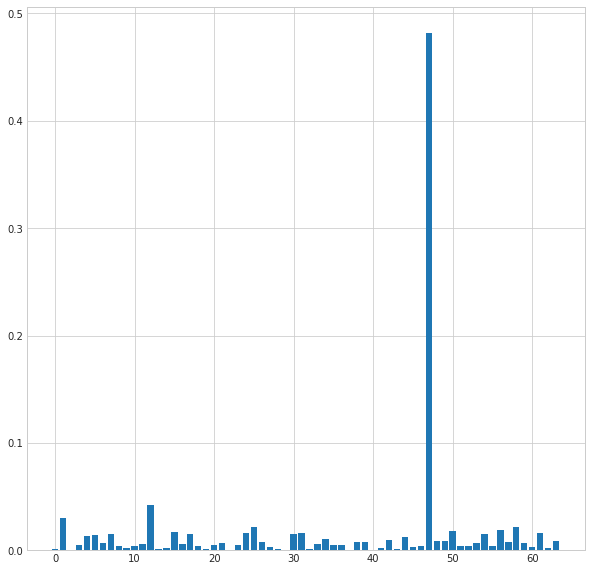

In [216]:
fig = plt.figure(figsize=(10, 10))
plt.bar(range(len(rmodel.feature_importances_)), rmodel.feature_importances_)
plt.show()

##  Vamos a quitar la variable de mas peso para ver que efecto puede tener sobre el modelo

In [217]:
X2_pred09 = df_2009.drop(['Unnamed: 0','Código municipio', 'Municipio', 
                         '2009_48','2011_elecc','2011_partic'], axis=1).values

In [218]:
y = df_2009[['2011_elecc']].values

In [219]:
X2 = np.array(X2_pred09)

In [226]:
r_model=RandomForestRegressor(max_depth=11)
r_model.fit(X2,y)

/home/vant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [227]:
mean_squared_error(df_2009['2011_elecc'],r_model.predict(X2))

6.469360329025361

In [228]:
X2_pred13 = df_2013.drop(['Unnamed: 0','Código municipio', '2013_48',
                         'Municipio','2015_elecc','2015_partic'], axis=1).values

In [229]:
X3 = np.array(X2_pred13)

In [230]:
mean_squared_error(df_2013['2015_elecc'],r_model.predict(X3))

47.67045192783483

## El error cuadratico medio no ha mejorado practicamente

## Eso si, ahora tenemos un peso mas distribuido entra las variables

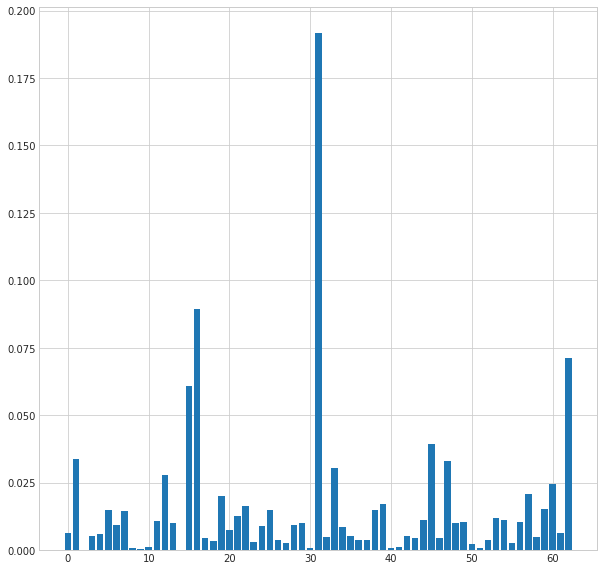

In [231]:
fig = plt.figure(figsize=(10, 10))
plt.bar(range(len(r_model.feature_importances_)), r_model.feature_importances_)
plt.show()

In [232]:
mean_squared_error(df_2013['2015_elecc'],d_model.predict(X1))

57.94547501226341

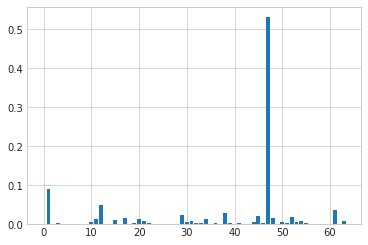

In [233]:
pyplot.bar(range(len(d_model.feature_importances_)), d_model.feature_importances_)
pyplot.show()

In [234]:
mean_squared_error(df_2013['2015_elecc'],k_model.predict(X1))

69.30589877551022

In [235]:
mean_squared_error(df_2013['2015_elecc'],lmodel.predict(X1))

2218695.2993047936

## Ahora utilizamos el modelo entrenado para prediccir la participacion electoral en cada municipio vasco el proximo Mayo del año 2019

In [5]:
df_2017 = pd.read_csv('../TFM/1_Data/GDataframe_2017.csv')

In [6]:
X_pred17 = df_2017.drop(['Unnamed: 0','Código municipio', 'Municipio'], axis=1).values

In [238]:
X2 = np.array(X_pred17)

In [239]:
pred_19 = pd.DataFrame(rmodel.predict(X2))

In [240]:
pred_19.columns = ['part_pred_2019'] 

In [241]:
Part_pred_19 = pred_19['part_pred_2019'].apply(part_integ)

In [7]:
predicc_17 = pd.read_csv('../TFM/1_Data/df_foto_pred17.csv')

In [8]:
prediccion_17 = predicc_17.drop('Unnamed: 0', axis=1)

In [244]:
Elecciones_2019 = pd.concat([prediccion_17, Part_pred_19], axis=1)

In [245]:
Elecciones_2019.to_csv('Elecciones_2019.csv')